In [185]:
from data_collection import btc_df
from data_collection import eth_df
from data_collection import sp500_df
from data_collection import gold_df

import matplotlib.pyplot as plt
from arch import arch_model
import pandas as pd
import numpy as np

## Modelling volatility using GARCH

Generalized Autoregressive Conditional Hetereoskedasticity) model is a statistical model used for modelling and forecasting the variance of time series data, and is widely known for use in financial markets. We have already mentioned the concept of an autoregressive process in ARMA-models where current returns depends on past returns. For GARCH-models, the conditional variance of a time series is modelled based on values of past variance terms and past squared residuals. As with the ARMA model-selection, information criterias such as AIC, SBIC and HQIC can be used for the selection of the GARCH(p,q) parameters;

p: the number of lags of the conditional variance  
q: the number of lags of the squared residuals

In this section, we will explore whether a GARCH model can effectively capture the volatility of the two major cryptocurrencies in this report, Bitcoin (BTC) and Ethereum (ETH). We will then compare the results before applying the same approach to S&P 500 and gold returns.

### Reasoning for choosing to model using GARCH

After studying the various models available for modeling volatility, we decided to use GARCH. Although we could have first attempted to model the volatility with ARCH, we chose to skip this step since GARCH is a natural extension of the ARCH model. ARCH has well-known limitations, including the challenge of determining the optimal number of lags for the squared residuals and the potential need for a large number of parameters to capture all the conditional variance dependence (Brooks, 2019, P.511). With a high number of lags, the likelihood of violating the non-negativity constraint in ARCH models also increases. Furthermore, GARCH models are more widely used in practice, making it an obvious choice for our analysis (Brooks, 2019, p. 511).

### Pre-analysis
Before proceeding with the volatility modelling, we first want to highlight a few key characteristics observed in the return plots of the assets shown in the Data Analysis section. These include volatility clustering, volatility spikes, and mean-reverting behaviour.

First, volatility clustering, also known as volatility pooling,  refers to the tendency for large positive returns to be followed by large positive returns, and large negative returns to be followed by large negative returns (Brooks, 2019, p. 498). This pattern, commonly seen in financial markets, is clearly visible in the return plots of all assets in our dataset. The returns tend to form distinct periods of high and low volatility, giving them a wave-looking appearance. This is a symptom of heteroskedasticity and is explicitly accounted for with GARCH, due to modelling the current condtional variance based on previous conditional variance.

Secondly, we also see that volatility during negative returns tends to be larger than during positive returns. This asymmetry is known as the leverage effect (Brooks, 2019, p.498). The leverage effect is not accounted for by standard GARCH but can be captured by the EGARCH model (Brooks, 2019, p. 522–523). However, since the effect appears small in the plots from the Data Analysis section, we leave exploring EGARCH for future research.

Lastly, we observe that all assets have constants mean around zero and that returns revert towards the mean. Therefore, the variance shocks also reverts after larger shocks. This is important because it implies that the unconditional variance remains stationary despite heteroskedasticity. Therefore, we must ensure that our GARCH parameters do not result in a non-stationary variance or introduce unit roots, as this would prevent the volatility shocks from reverting after larger shocks (Brooks, 2019, p. 514-515). 





### Information Criteria

**Function for computing Information Criterias**

In [186]:
def informationCriteriasGARCH(df, p_range, q_range):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Here we defined the values we want to iterate through for p and q
    p_range = range(1, p_range)
    q_range = range(1, q_range)

    results = []

    # Here we loop over all combinations of p and q, and calculate the AIC, SBIC and HQIC for each GARCH(p,q)
    for p in p_range:
        for q in q_range:
            # Here we multiplied return by 100 to prevent small-values, making the optimization more stable.
            model = arch_model((df['Return']*100).dropna(), vol='Garch', p=p, q=q)
            garch_fit = model.fit(disp="off")  # Suppress output

            # Here we compute HQIC manually, since the library does not support HQIC
            log_likelihood = garch_fit.loglikelihood
            num_obs = len(df['Return'].dropna())
            num_params = p + q + 1
            hqic = -2 * log_likelihood + 2.0 * num_params * np.log(np.log(num_obs))

            # Store the results
            results.append([p, q, garch_fit.aic, garch_fit.bic, hqic])
            
    garch_results_df = pd.DataFrame(results, columns=['p', 'q', 'AIC', 'SBIC', 'HQIC'])
    print(garch_results_df)

    best_aic = garch_results_df.loc[garch_results_df['AIC'].idxmin()]
    best_sbic = garch_results_df.loc[garch_results_df['SBIC'].idxmin()]
    best_hqic = garch_results_df.loc[garch_results_df['HQIC'].idxmin()]

    print("\nBest model based on AIC:")
    print(best_aic[0:2])
    print("\nBest model based on SBIC:")
    print(best_sbic[0:2])
    print("\nBest model based on HQIC:")
    print(best_hqic[0:2])

We constructed a table testing the AIC, SBIC, and HQIC scores on GARCH(p, q) for all permutations of the p and q parameters. To account for computational complexity, we only tested for p and q less than 10. In all cases except for gold, the information criteria suggested different optimal parameters. However, since we wanted to favor fewer parameters and the datasets are relatively large, we concluded that always following the SBIC criterion would be optimal, as it imposes a stricter penalty term (Brooks, 2019, p. 360-361)

**Function for fitting a GARCH model and printing the summary**

In [187]:
def fitGARCH(df,p,q):
    # Keep in mind that the information criteria will be scaled different in this summary, due to not scaling the Return
    model = arch_model(df['Return'].dropna(), vol='Garch', p=p, q=q, rescale=False)
    garch_fit = model.fit()
    print(garch_fit.summary())
    return garch_fit

**Function for plotting the GARCH model against the return for comparison**

In [188]:
def plot_results(garch, df):
    conditional_volatility = garch.conditional_volatility

    # We trim to make the lengths of the dataframes match.
    df_trimmed = df.iloc[len(df)-len(conditional_volatility):]
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # GARCH Conditional volatility
    ax1.plot(df_trimmed.index, conditional_volatility, color='tab:red', label='Conditional Volatility (GARCH)', linewidth=1)
    ax1.set_ylabel('Conditional Volatility')
    ax1.set_title('Conditional Volatility from GARCH Model')
    ax1.legend(loc='upper left')

    # Return
    ax2.plot(df_trimmed.index, df_trimmed['Return'], color='tab:blue', label='Return', linewidth=1)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Return')
    ax2.set_title('Regular Returns')
    ax2.legend(loc='upper left')

    fig.tight_layout()
    plt.show()

### GARCH Modelling Bitcoin (BTC)

In [189]:
informationCriteriasGARCH(btc_df,10,10)

    p  q           AIC          SBIC          HQIC
0   1  1  19694.282382  19719.207886  19698.930101
1   1  2  19690.770263  19721.927143  19697.633889
2   1  3  19674.572069  19711.960326  19683.651601
3   1  4  19676.572069  19720.191701  19687.867507
4   1  5  19678.572069  19728.423077  19692.083414
.. .. ..           ...           ...           ...
76  9  5  19678.198121  19777.900138  19709.436717
77  9  6  19677.227112  19783.160505  19710.681615
78  9  7  19679.227112  19791.391881  19714.897521
79  9  8  19681.227114  19799.623259  19719.113429
80  9  9  19683.637104  19808.264625  19723.739325

[81 rows x 5 columns]

Best model based on AIC:
p    4.0
q    4.0
Name: 30, dtype: float64

Best model based on SBIC:
p    1.0
q    3.0
Name: 2, dtype: float64

Best model based on HQIC:
p    1.0
q    3.0
Name: 2, dtype: float64


In [190]:
btc_GARCH = fitGARCH(btc_df,1,3)

Iteration:      1,   Func. Count:      8,   Neg. LLF: 94934610874.37746
Iteration:      2,   Func. Count:     22,   Neg. LLF: 52111.969546758
Iteration:      3,   Func. Count:     33,   Neg. LLF: 23442.113273261682
Iteration:      4,   Func. Count:     44,   Neg. LLF: 15877.830529195251
Iteration:      5,   Func. Count:     55,   Neg. LLF: 9784.168427257795
Iteration:      6,   Func. Count:     67,   Neg. LLF: -7172.959061681631
Iteration:      7,   Func. Count:     75,   Neg. LLF: -7292.350091687214
Iteration:      8,   Func. Count:     83,   Neg. LLF: -7269.136798392421
Iteration:      9,   Func. Count:     91,   Neg. LLF: -7354.81337387291
Iteration:     10,   Func. Count:     99,   Neg. LLF: -7367.0422280306475
Iteration:     11,   Func. Count:    107,   Neg. LLF: -7469.644282690751
Iteration:     12,   Func. Count:    115,   Neg. LLF: -7428.002642679299
Iteration:     13,   Func. Count:    124,   Neg. LLF: -6352.248574222778
Iteration:     14,   Func. Count:    134,   Neg. LLF: -7

In [191]:
fitGARCH(btc_df,1,1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1470925.7267345642
Iteration:      2,   Func. Count:     18,   Neg. LLF: 26046334151872.26
Iteration:      3,   Func. Count:     32,   Neg. LLF: 16040.967732893048
Iteration:      4,   Func. Count:     42,   Neg. LLF: 926097012766029.5
Iteration:      5,   Func. Count:     56,   Neg. LLF: 981690809.86743
Iteration:      6,   Func. Count:     67,   Neg. LLF: 4458168383.568587
Iteration:      7,   Func. Count:     79,   Neg. LLF: 53630662.25214547
Iteration:      8,   Func. Count:     89,   Neg. LLF: 2.1910576535565704e+18
Iteration:      9,   Func. Count:    100,   Neg. LLF: -7449.674380741826
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7449.674373846845
            Iterations: 13
            Function evaluations: 100
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:       

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7449.67
Distribution:                  Normal   AIC:                          -14891.3
Method:            Maximum Likelihood   BIC:                          -14866.4
                                        No. Observations:                 3757
Date:                Fri, Apr 04 2025   Df Residuals:                     3756
Time:                        11:24:45   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         2.0324e-03  5.114e-04      3.974  7.058e-05 [1.

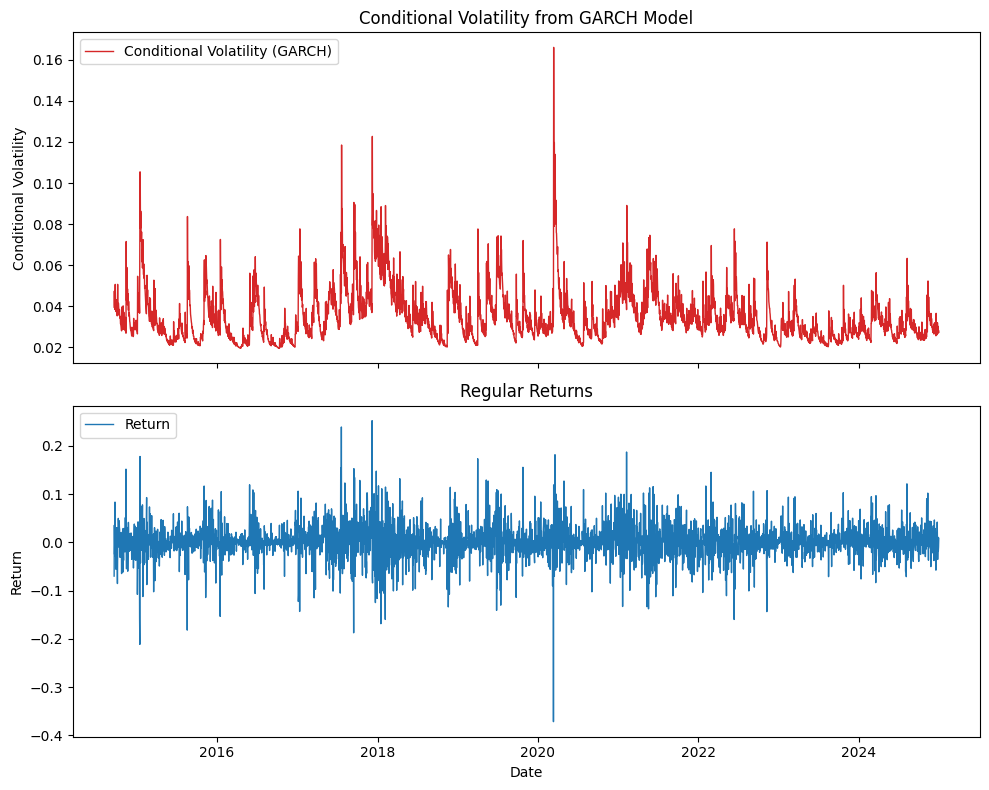

In [192]:
plot_results(btc_GARCH, btc_df)

**Bitcoin:** 
* Optimal parameter values according to BIC:   p=1, q=3
* All parameters except β_2 are significant at the 0.05 confidence level.
* Model is stationarity in variance.

The information criteria indicates that the model might be a good fit, however the insignificance of β_2 suggests that further refinement and comparison with other models could provide a better model. Therefore, we tried to compare the GARCH(1,3) model with a GARCH(1,1) model for this asset. This change resulted in a reduction in the log-likelihood indicating a worse fit. Based on this observation, we decided to stick with the GARCH(1,3) model and concluded that a better-fitting model might be found outside the standard GARCH framework, which we as previously mentioned have left for future research.

As we see on the plots comparing the GARCH(1,3) model with the returns, the model captures volatility clustering well, with higher conditional volatility during periods of large returns. All sharp spikes seems to be caught by the model, which indicates a seemingly good fit. However, as discussed exploring EGARCH or other extensions could improve fit, and should be furthered research in the future.


### GARCH Modelling Ethereum (ETH)

In [193]:
informationCriteriasGARCH(eth_df,10,10)

    p  q           AIC          SBIC          HQIC
0   1  1  14974.692492  14998.159381  14979.068341
1   1  2  14973.465134  15002.798745  14979.966266
2   1  3  14964.150253  14999.350586  14972.776668
3   1  4  14966.150252  15007.217308  14976.901950
4   1  5  14968.150252  15015.084030  14981.027233
.. .. ..           ...           ...           ...
76  9  5  14982.794380  15076.661937  15012.673625
77  9  6  14981.197447  15080.931726  15013.201975
78  9  7  14982.537731  15088.138732  15016.667542
79  9  8  14984.729641  15096.197365  15020.984735
80  9  9  14979.149784  15096.484230  15017.530161

[81 rows x 5 columns]

Best model based on AIC:
p    1.0
q    3.0
Name: 2, dtype: float64

Best model based on SBIC:
p    1.0
q    1.0
Name: 0, dtype: float64

Best model based on HQIC:
p    1.0
q    3.0
Name: 2, dtype: float64


In [194]:
eth_GARCH = fitGARCH(eth_df,1,1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3221685.4235006627
Iteration:      2,   Func. Count:     17,   Neg. LLF: 8925434.149676675
Iteration:      3,   Func. Count:     28,   Neg. LLF: 562087.5357416891
Iteration:      4,   Func. Count:     40,   Neg. LLF: 397110.608595574
Iteration:      5,   Func. Count:     51,   Neg. LLF: 172417.42827337288
Iteration:      6,   Func. Count:     61,   Neg. LLF: -4528.594038850997
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4528.5940444908065
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 6
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4528.59
Distribution:                  Normal   

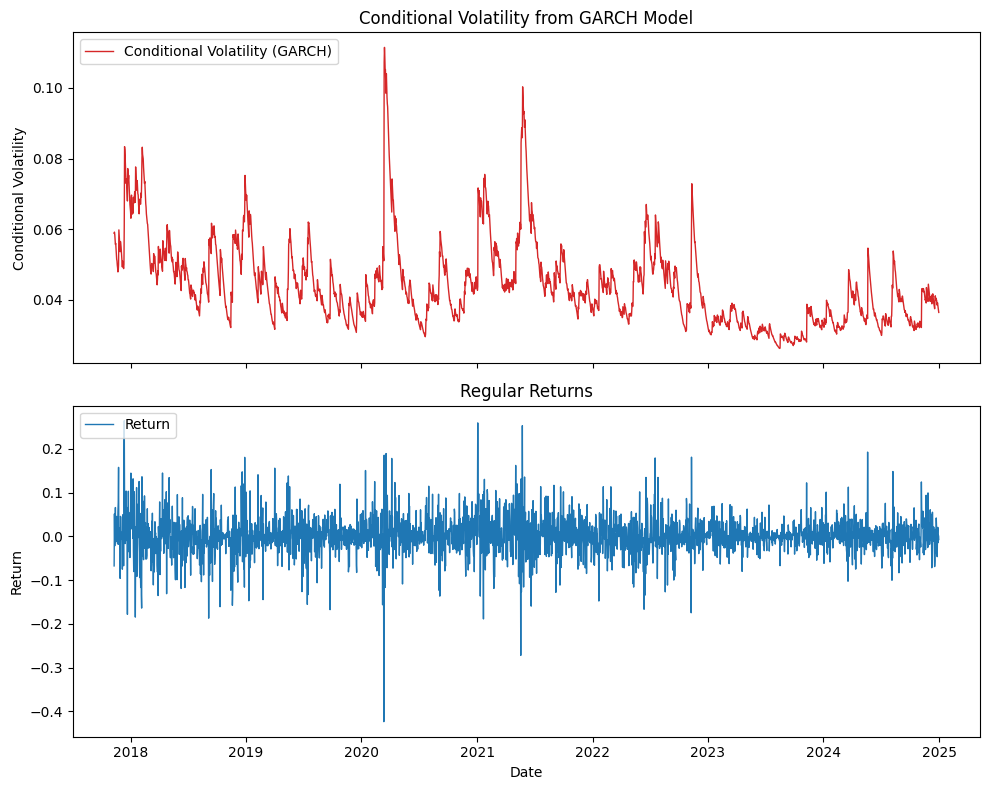

In [195]:
plot_results(eth_GARCH, eth_df)

**Ethereum:**
* Optimal parameter values according to BIC:   p=1, q=1
* All parameters are significant at the 0.05 confidence level.
* Model is stationarity in variance.

As seen in the plots, the GARCH(1,1) model captures volatility clustering well, with higher conditional volatility during large return movements. For example, the spike around 2020 aligns with increased volatility in returns, suggesting a good fit.

### GARCH Modelling S&P 500

In [196]:
informationCriteriasGARCH(sp500_df,10,10)

    p  q          AIC         SBIC         HQIC
0   1  1  9685.047461  9709.989964  9689.698277
1   1  2  9687.047461  9718.225590  9693.915216
2   1  3  9689.047461  9726.461215  9698.132154
3   1  4  9691.047461  9734.696841  9702.349093
4   1  5  9693.047461  9742.932467  9706.566032
.. .. ..          ...          ...          ...
76  9  5  9702.378732  9802.148743  9733.632812
77  9  6  9704.053525  9810.059163  9737.524544
78  9  7  9706.061567  9818.302830  9741.749525
79  9  8  9708.376024  9826.852913  9746.280921
80  9  9  9709.976557  9834.689072  9750.098393

[81 rows x 5 columns]

Best model based on AIC:
p    2.0
q    2.0
Name: 10, dtype: float64

Best model based on SBIC:
p    1.0
q    1.0
Name: 0, dtype: float64

Best model based on HQIC:
p    1.0
q    1.0
Name: 0, dtype: float64


In [197]:
sp500_GARCH = fitGARCH(sp500_df,1,1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.0243797811448945e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 7.931933202427314e+26
Iteration:      3,   Func. Count:     35,   Neg. LLF: 8.70483909234605e+26
Iteration:      4,   Func. Count:     50,   Neg. LLF: 1.8471639031697108e+24
Iteration:      5,   Func. Count:     65,   Neg. LLF: 482597627650.21387
Iteration:      6,   Func. Count:     77,   Neg. LLF: 7687407273.704859
Iteration:      7,   Func. Count:     90,   Neg. LLF: 4647693061.314399
Iteration:      8,   Func. Count:    102,   Neg. LLF: -12517.899759049116
Optimization terminated successfully    (Exit mode 0)
            Current function value: -12517.899777222416
            Iterations: 12
            Function evaluations: 102
            Gradient evaluations: 8
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Me

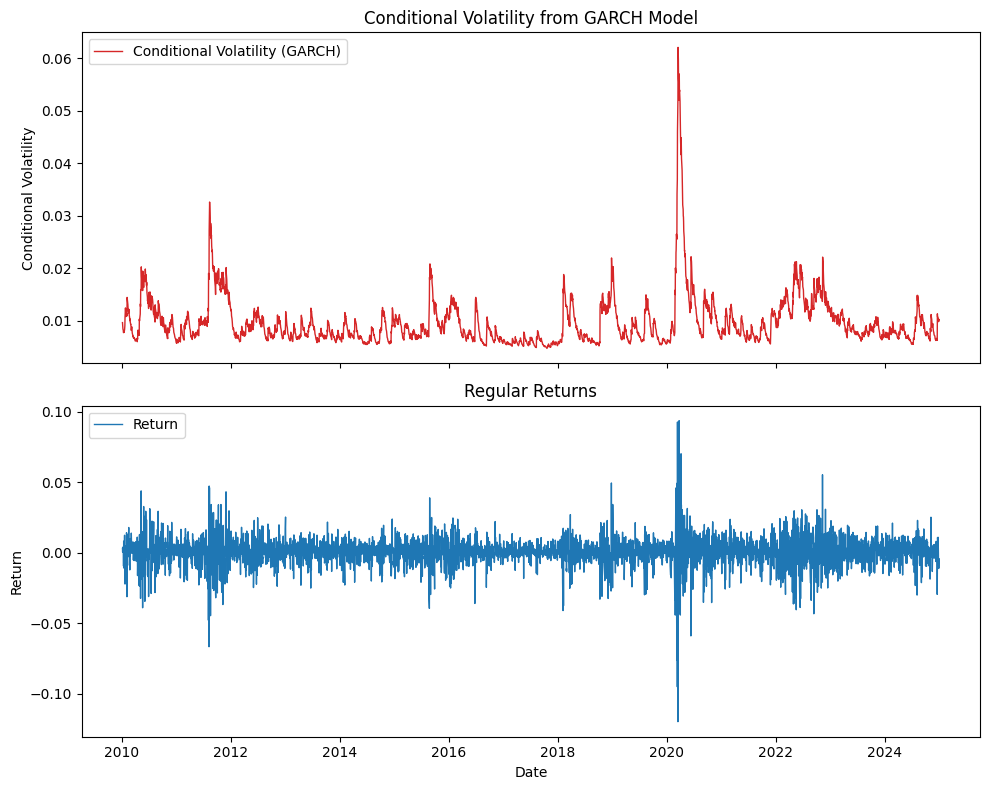

In [198]:
plot_results(sp500_GARCH, sp500_df)

**S&P500:**
* Optimal parameter values according to BIC:   p=1, q=1
* All parameters are significant at the 0.05 confidence level.
* Model is stationarity in variance.

As seen in the plots comparing the GARCH(1,1) model with the returns, the model effectively captures volatility clustering. For instance, the sharp volatility spikes following the large return swings around 2011 and 2020 are well-modeled, indicating a generally good fit.


### GARCH Modelling Gold (GC=F)

In [199]:
informationCriteriasGARCH(gold_df,10,10)

    p  q           AIC          SBIC          HQIC
0   1  1  10379.766542  10404.705863  10384.416778
1   1  2  10381.328246  10412.502397  10388.195228
2   1  3  10383.212450  10420.621432  10392.296178
3   1  4  10384.493569  10428.137381  10395.794042
4   1  5  10384.964625  10434.843267  10398.481844
.. .. ..           ...           ...           ...
76  9  5  10399.773189  10499.530473  10431.024371
77  9  6  10390.401660  10496.393775  10423.869588
78  9  7  10390.381784  10502.608729  10426.066458
79  9  8  10392.970461  10511.432236  10430.871880
80  9  9  10390.872343  10515.568949  10430.990508

[81 rows x 5 columns]

Best model based on AIC:
p    1.0
q    1.0
Name: 0, dtype: float64

Best model based on SBIC:
p    1.0
q    1.0
Name: 0, dtype: float64

Best model based on HQIC:
p    1.0
q    1.0
Name: 0, dtype: float64


In [200]:
gold_GARCH = fitGARCH(gold_df,1,1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.5836546022530017e+20
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7176.224903242255
Iteration:      3,   Func. Count:     28,   Neg. LLF: 110192488.10071316
Iteration:      4,   Func. Count:     41,   Neg. LLF: 19186029460.634846
Optimization terminated successfully    (Exit mode 0)
            Current function value: -12174.249617789923
            Iterations: 6
            Function evaluations: 51
            Gradient evaluations: 4
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                12174.2
Distribution:                  Normal   AIC:                          -24340.5
Method:            Maximum Likelihood   BIC:                          -24315.6
                      

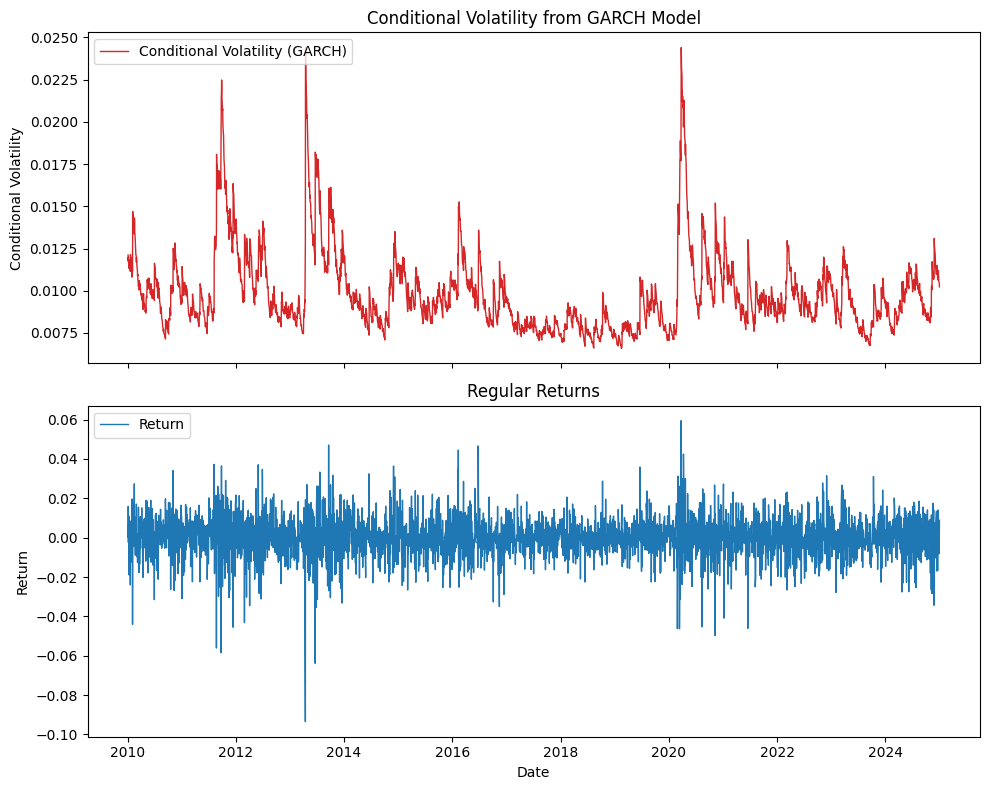

In [201]:
plot_results(gold_GARCH, gold_df)

**Gold:**
* Optimal parameter values according to BIC:   p=1, q=1
* All parameters are significant at the 0.05 confidence level.
* Model is stationarity in variance.

Again, the GARCH(1,1) models volatility effectively. However, the spikes around 2011 and 2020 appear exaggerated compared to 2013, suggesting that an extended GARCH model could provide a better fit than this general GARCH, when testing this in the future.


### Conclusion
We have managed to model the conditional variance of Bitcoin, Ethereum, S&P500 and gold using GARCH models. All models except Bitcoin obtaiend optimal results using the GARCH(1,1) model, which we expected since GARCH rarely needs any higher order than p=1 and q=1 to capture the volatility clustering in the data,  according to academic finance litterature (Brooks, 2019, p. 514).